In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [30]:
final_coef = []
final_int = 0

In [18]:
original_data = pd.read_csv('prices_round_1_day_-1.csv', delimiter = ';')
data = original_data[original_data['product'] == 'STARFRUIT']['mid_price']
df = pd.DataFrame()
df['price']=data
df['price_lag1']=df['price'].shift(1)
df['price_lag2']=df['price'].shift(2)
df['price_lag3']=df['price'].shift(3)
df['price_lag4']=df['price'].shift(4)
df['price_50'] = np.log1p(original_data[original_data['product'] == 'STARFRUIT']['mid_price'].pct_change(50)).shift(-50)
df.dropna(inplace=True)
df

,price,price_lag1,price_lag2,price_lag3,price_lag4,price_50
9,5042.5,5043.0,5044.0,5043.0,5046.0,-0.000595
10,5042.5,5042.5,5043.0,5044.0,5043.0,-0.000397
13,5044.0,5042.5,5042.5,5043.0,5044.0,-0.000297
15,5044.0,5044.0,5042.5,5042.5,5043.0,-0.001488
17,5042.5,5044.0,5044.0,5042.5,5042.5,-0.000397
...,...,...,...,...,...,...
19890,5044.0,5044.5,5046.0,5045.5,5046.0,-0.000496
19893,5044.5,5044.0,5044.5,5046.0,5045.5,-0.000496
19895,5044.5,5044.5,5044.0,5044.5,5046.0,-0.000793
19897,5043.0,5044.5,5044.5,5044.0,5044.5,-0.000694


In [29]:
for filepath in ['prices_round_1_day_-1', 'prices_round_1_day_-2', 'prices_round_1_day_0']:
    data = pd.read_csv(f'{filepath}.csv', delimiter = ';')
    data = data[data['product'] == 'STARFRUIT']['mid_price'].pct_change()
    df = pd.DataFrame()
    df['price']=np.log1p(data)
    df['returns_lag1']=df['price'].shift(1)
    df['returns_lag2']=df['price'].shift(2)
    df['returns_lag3']=df['price'].shift(3)
    df['returns_lag4']=df['price'].shift(4)
    df['returns_50'] = np.log1p(data[data['product'] == 'STARFRUIT']['mid_price'].pct_change(50)).shift(-50)
    df.dropna(inplace=True)
    X = df[['returns_lag1', 'returns_lag2', 'returns_lag3', 'returns_lag4']]
    y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Running a linear regression
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Coefficients and intercept
    coefficients = model.coef_
    intercept = model.intercept_
    final_coef.append(model.coef_.tolist())
    final_int += intercept 

KeyError: 'product'

In [33]:
#Regressing on prices
final_coef = []
final_int = 0
for filepath in ['prices_round_1_day_-1', 'prices_round_1_day_-2', 'prices_round_1_day_0']:
    data = pd.read_csv(f'{filepath}.csv', delimiter = ';')
    data = data[data['product'] == 'STARFRUIT']['mid_price']
    df = pd.DataFrame()
    df['price'] = data
    df['price_lag1']=df['price'].shift(1)
    df['price_lag2']=df['price'].shift(2)
    df['price_lag3']=df['price'].shift(3)
    df['price_lag4']=df['price'].shift(4)
    df.dropna(inplace=True)
    X = df[['price_lag1', 'price_lag2', 'price_lag3', 'price_lag4']]
    y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Running a linear regression
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Coefficients and intercept
    coefficients = model.coef_
    intercept = model.intercept_
    final_coef.append(model.coef_.tolist())
    final_int += intercept 
    print(filepath, final_coef)

prices_round_1_day_-1 [[0.33131025813715154, 0.26368179628919064, 0.22441039135738333, 0.17790392975166422]]
prices_round_1_day_-2 [[0.33131025813715154, 0.26368179628919064, 0.22441039135738333, 0.17790392975166422], [0.33780155328198286, 0.2556087032175788, 0.1963882124089581, 0.2097774897401313]]
prices_round_1_day_0 [[0.33131025813715154, 0.26368179628919064, 0.22441039135738333, 0.17790392975166422], [0.33780155328198286, 0.2556087032175788, 0.1963882124089581, 0.2097774897401313], [0.3375294642425579, 0.26181038631777537, 0.19284218357482144, 0.20392870580237416]]


In [34]:
final_int /= 3
final_coefs = [sum(col) / len(col) for col in zip(*final_coef)]

In [35]:
final_int

11.802383435338925

In [36]:
final_coefs

[0.33554709188723075,
 0.26036696194151493,
 0.20454692911372097,
 0.19720337509805655]

In [8]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt

def make_stationary(series):
    """ Apply differencing until the series passes the ADF test for stationarity. """
    result = adfuller(series)
    p_value = result[1]
    if p_value < 0.05:
        return series, 0  # Already stationary
    diff_count = 0
    while p_value >= 0.05:
        series = series.diff().dropna()
        result = adfuller(series)
        p_value = result[1]
        diff_count += 1
    return series, diff_count

def fit_ar_model(series, lags):
    """ Fit an AR model and return the coefficients. """
    model = AutoReg(series, lags=lags, old_names=False)
    model_fitted = model.fit()
    return model_fitted.params

def analyze_log_price(log_price):
    """ Analyze log price, make series stationary, plot PACF, and fit AR model. """
    stationary_series, diff_count = make_stationary(log_price)
    lag_pacf = pacf(stationary_series, nlags=20, method='ols')

    # Plotting the PACF
    plt.figure(figsize=(10, 5))
    plt.stem(range(len(lag_pacf)), lag_pacf)
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.show()

    # Ask user for the AR model order based on the PACF plot
    order = int(input("Enter the order of the AR model based on the PACF plot: "))
    coefficients = fit_ar_model(stationary_series, order)
    
    return coefficients

In [9]:
ar_coefs = []
ar_int = 0

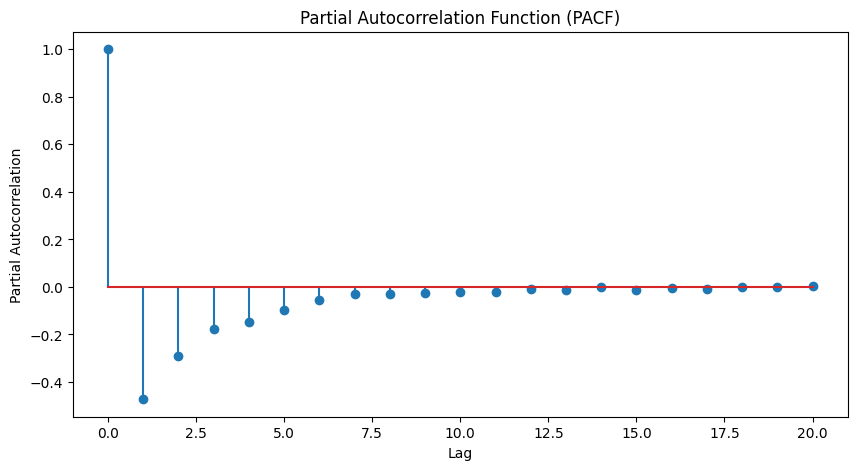

Enter the order of the AR model based on the PACF plot:  6


/Users/ommehta/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/q1/n178rnzj65bdl86f8t6tlscc0000gq/T/ipykernel_14834/1329572837.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ar_int += output[0]


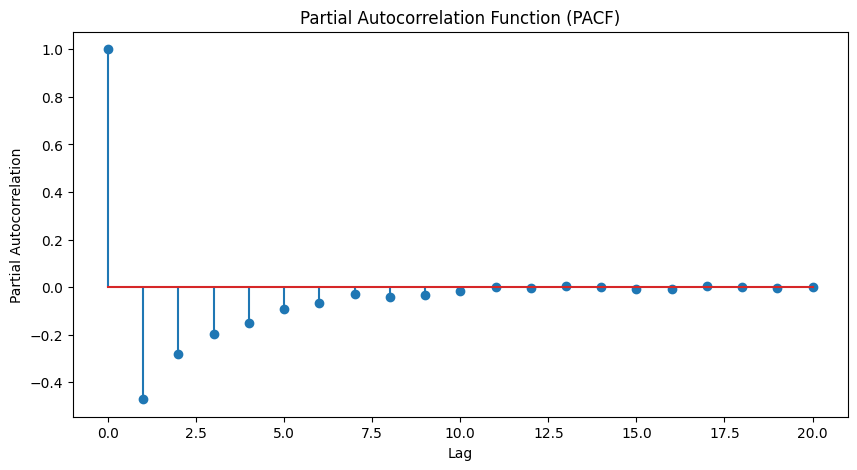

Enter the order of the AR model based on the PACF plot:  6


/Users/ommehta/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/q1/n178rnzj65bdl86f8t6tlscc0000gq/T/ipykernel_14834/1329572837.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ar_int += output[0]


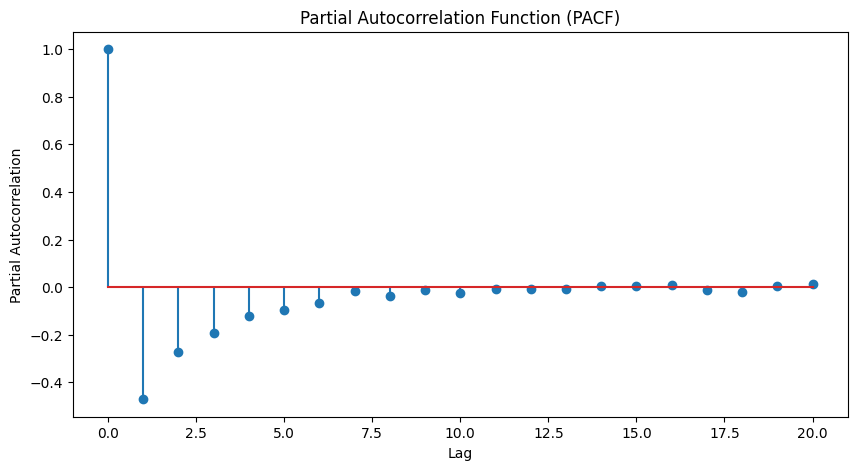

Enter the order of the AR model based on the PACF plot:  6


All coefs:  [returns.L1   -0.706367
returns.L2   -0.494965
returns.L3   -0.333115
returns.L4   -0.237602
returns.L5   -0.132062
returns.L6   -0.052941
dtype: float64, returns.L1   -0.709587
returns.L2   -0.504613
returns.L3   -0.363722
returns.L4   -0.248150
returns.L5   -0.138744
returns.L6   -0.066787
dtype: float64, returns.L1   -0.694820
returns.L2   -0.475921
returns.L3   -0.335840
returns.L4   -0.218473
returns.L5   -0.142192
returns.L6   -0.065051
dtype: float64]
AR Coefs:  [-0.703591491407734, -0.4918330007028236, -0.3442257990494724, -0.23474182959132742, -0.13766592122288243, -0.06159321908371221]
AR Intercept:  1.0285830994358876e-06


/Users/ommehta/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/q1/n178rnzj65bdl86f8t6tlscc0000gq/T/ipykernel_14834/1329572837.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ar_int += output[0]


In [10]:
for filepath in ['prices_round_1_day_-1', 'prices_round_1_day_-2', 'prices_round_1_day_0']:
    data = pd.read_csv(f'{filepath}.csv', delimiter = ';')
    data = data[data['product'] == 'STARFRUIT']['mid_price'].pct_change()
    df = pd.DataFrame()
    df['price']=np.log1p(data).dropna()
    output = analyze_log_price(df['price'])
    ar_coefs.append(output[1:])
    ar_int += output[0]

print('All coefs: ', ar_coefs)
final_coefs_ar = [sum(col) / len(col) for col in zip(*ar_coefs)]
print('AR Coefs: ', final_coefs_ar)
print('AR Intercept: ', ar_int/3)